In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

In [2]:
#Fetch Market Data
selected_tickers = ['TATASTEEL.NS', 'ADANIENT.NS', 'INDUSINDBK.NS', 'SHRIRAMFIN.NS','TATAMOTORS.NS', 'HINDALCO.NS', 'BEL.NS', 'ONGC.NS', 'BAJFINANCE.NS','HINDUNILVR.NS', 'ULTRACEMCO.NS', 'HDFCLIFE.NS', 'BHARTIARTL.NS','COALINDIA.NS', 'SUNPHARMA.NS']
start_date = '2020-01-01'
end_date = '2025-01-01'
data = yf.download(selected_tickers, start=start_date, end=end_date)
returns = data['Close'].pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  15 of 15 completed


In [3]:
import requests
from bs4 import BeautifulSoup

def get_rbi_gsec_yield():
    url = "https://www.rbi.org.in/Scripts/BS_PressReleaseDisplay.aspx"  # Change URL based on latest data
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        yield_value = None
        return yield_value / 100 if yield_value else 0.07

    return 0.07

risk_free_rate = get_rbi_gsec_yield()
print("Risk-Free Rate from RBI:", risk_free_rate)

Risk-Free Rate from RBI: 0.07


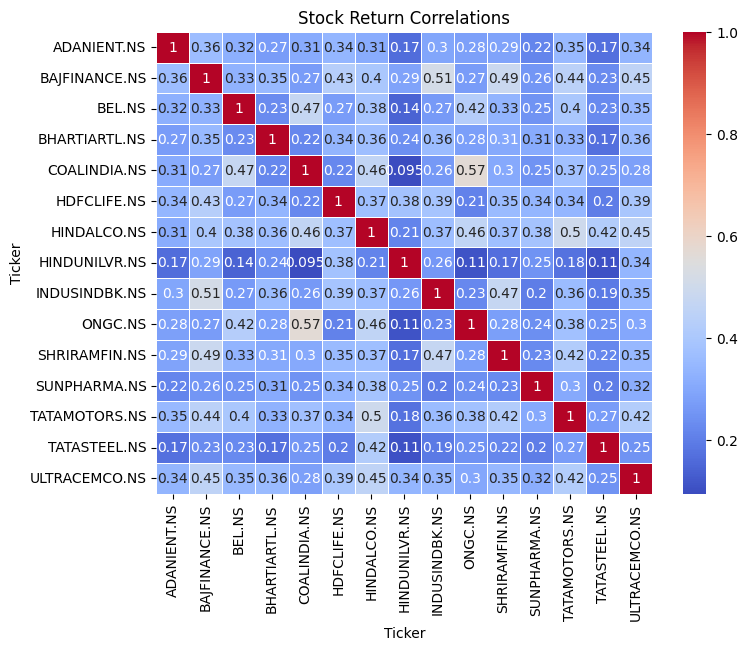

Ticker
TATASTEEL.NS    -1.830801
ADANIENT.NS     -1.974623
INDUSINDBK.NS   -2.226467
SHRIRAMFIN.NS   -2.259843
TATAMOTORS.NS   -2.553315
HINDALCO.NS     -2.638147
BEL.NS          -2.803695
ONGC.NS         -2.832210
BAJFINANCE.NS   -2.882427
COALINDIA.NS    -3.332226
HDFCLIFE.NS     -3.618380
BHARTIARTL.NS   -3.841202
ULTRACEMCO.NS   -3.959422
SUNPHARMA.NS    -4.259645
HINDUNILVR.NS   -4.605455
dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Stock Return Correlations")
plt.show()

stock_sharpe = (returns.mean() - risk_free_rate) / returns.std()
print(stock_sharpe.sort_values(ascending=False))

In [5]:
#Market Equilibrium Returns
market_index = yf.download('^NSEI', start=start_date, end=end_date)['Close'].pct_change().dropna()
market_index.name = "^NSEI"
returns["^NSEI"] = market_index

market_eq_returns = returns.mean()

[*********************100%***********************]  1 of 1 completed


In [6]:
valid_tickers = returns.columns.tolist()
P = np.zeros((7, len(valid_tickers)))  # 7 views
Q = np.array([0.02, -0.015, 0.01, -0.02, 0.018, 0.012, 0.015]).reshape(-1, 1)

ticker_mapping = {
    "TATASTEEL.NS": (0, 1),
    "HINDALCO.NS": (0, -1),
    "ONGC.NS": (1, 1),
    "SHRIRAMFIN.NS": (1, -1),
    "ADANIENT.NS": (2, -1),
    "BAJFINANCE.NS": (2, 1),
    "INDUSINDBK.NS": (3, -1),
    "BEL.NS": (3, 1),
    "HINDUNILVR.NS": (4, 1),
    "ULTRACEMCO.NS": (4, 1),
    "HDFCLIFE.NS": (5, 1),
    "BHARTIARTL.NS": (5, 1),
    "COALINDIA.NS": (6, 1),
    "SUNPHARMA.NS": (6, 1)
}



for stock, (row, val) in ticker_mapping.items():
    if stock in valid_tickers:
        P[row, valid_tickers.index(stock)] = val

In [7]:
print(returns.shape[1])
print(returns.columns)

16
Index(['ADANIENT.NS', 'BAJFINANCE.NS', 'BEL.NS', 'BHARTIARTL.NS',
       'COALINDIA.NS', 'HDFCLIFE.NS', 'HINDALCO.NS', 'HINDUNILVR.NS',
       'INDUSINDBK.NS', 'ONGC.NS', 'SHRIRAMFIN.NS', 'SUNPHARMA.NS',
       'TATAMOTORS.NS', 'TATASTEEL.NS', 'ULTRACEMCO.NS', '^NSEI'],
      dtype='object', name='Ticker')


In [8]:
# Compute Omega
confidence_factor = 0.5
omega = confidence_factor * np.diag(np.diag(P @ returns.cov().values @ P.T)) + np.eye(P.shape[0]) * 1e-2

In [9]:
tau = 0.05
regularization_strength = 0.001
cov_matrix = returns.cov().values + np.eye(len(valid_tickers)) * regularization_strength
inv_tau_cov = np.linalg.pinv(tau * cov_matrix)
inv_omega = np.linalg.pinv(omega)
M_inverse = np.linalg.pinv(inv_tau_cov + P.T @ inv_omega @ P)
posterior_mean = M_inverse @ (inv_tau_cov @ market_eq_returns.values.reshape(-1, 1) + P.T @ inv_omega @ Q)

# Normalize
posterior_mean = np.clip(posterior_mean * 100, -5, 5)

In [10]:
cov_matrix = returns.cov().values
rank = np.linalg.matrix_rank(cov_matrix)
print(f"Rank of Covariance Matrix: {rank} / {cov_matrix.shape[0]}")

Rank of Covariance Matrix: 16 / 16


In [11]:
print("NaN values in returns:", returns.isna().sum().sum())
print("Constant columns:", (returns.std() == 0).sum())

NaN values in returns: 1
Constant columns: 0


In [12]:
returns = returns.dropna()

In [13]:
# Sector Classification
sector_mapping = {
    "TATASTEEL.NS": "Metals",
    "HINDALCO.NS": "Metals",
    "ONGC.NS": "Energy",
    "SHRIRAMFIN.NS": "Financials",
    "ADANIENT.NS": "Conglomerate",
    "BAJFINANCE.NS": "Financials",
    "INDUSINDBK.NS": "Financials",
    "BEL.NS": "Defense",
    "HINDUNILVR.NS": "FMCG",
    "ULTRACEMCO.NS": "Cement",
    "HDFCLIFE.NS": "Insurance",
    "BHARTIARTL.NS": "Telecom",
    "COALINDIA.NS": "Energy",
    "SUNPHARMA.NS": "Pharma"
}


# Define Sector Constraints
sector_limits = {
    "Metals": 0.30,
    "Financials": 0.40,
    "Energy": 0.25,
    "Conglomerate": 0.15,
    "Defense": 0.25,
    "FMCG": 0.20,
    "Pharma": 0.25,
    "Cement": 0.20,
    "Insurance": 0.15,
    "Telecom": 0.15
}


In [14]:
from scipy.optimize import LinearConstraint

def sector_constrained_optimization(returns, expected_returns, sector_mapping, sector_limits):
    num_assets = len(expected_returns)
    cov_matrix = np.cov(returns, rowvar=False) + np.eye(num_assets) * 1e-3

    # Define sector allocation matrix
    sector_matrix = np.zeros((len(sector_limits), num_assets))
    sector_index = {sector: i for i, sector in enumerate(sector_limits.keys())}

    for i, asset in enumerate(returns.columns):
        if asset in sector_mapping:
            sector = sector_mapping[asset]
            if sector in sector_index:
                sector_matrix[sector_index[sector], i] = 1

    sector_bounds = list(sector_limits.values())

    def objective(weights):
        portfolio_return = weights @ expected_returns.flatten()
        portfolio_volatility = np.sqrt(weights @ cov_matrix @ weights.T)
        return -((portfolio_return - risk_free_rate) / portfolio_volatility)

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'ineq', 'fun': lambda w: 0.30 - np.max(w)},
    ]

    sector_constraint = LinearConstraint(sector_matrix, lb=0, ub=sector_bounds)

    bounds = [(0.0025, 0.25)] * num_assets
    initial_weights = np.ones(num_assets) / num_assets

    result = minimize(objective, initial_weights, bounds=bounds, constraints=[*constraints, sector_constraint], method='SLSQP')

    return result.x if result.success else np.zeros(num_assets)

# Run
optimized_weights_sector = sector_constrained_optimization(returns, posterior_mean, sector_mapping, sector_limits)

print("\n Optimized Portfolio Weights with Sector Constraints:\n", optimized_weights_sector)

# Save
portfolio_allocation = pd.DataFrame({'Stock': returns.columns.tolist(), 'Weight': optimized_weights_sector})
print(portfolio_allocation.sort_values(by='Weight', ascending=False))


 Optimized Portfolio Weights with Sector Constraints:
 [0.15       0.0025     0.21719551 0.09553777 0.01685166 0.0025
 0.0025     0.0025     0.0025     0.0025     0.07676177 0.15660271
 0.05143399 0.19297597 0.02514063 0.0025    ]
            Stock    Weight
2          BEL.NS  0.217196
13   TATASTEEL.NS  0.192976
11   SUNPHARMA.NS  0.156603
0     ADANIENT.NS  0.150000
3   BHARTIARTL.NS  0.095538
10  SHRIRAMFIN.NS  0.076762
12  TATAMOTORS.NS  0.051434
14  ULTRACEMCO.NS  0.025141
4    COALINDIA.NS  0.016852
9         ONGC.NS  0.002500
1   BAJFINANCE.NS  0.002500
6     HINDALCO.NS  0.002500
5     HDFCLIFE.NS  0.002500
7   HINDUNILVR.NS  0.002500
8   INDUSINDBK.NS  0.002500
15          ^NSEI  0.002500


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [15]:
print("Posterior Mean Returns:\n", posterior_mean)

Posterior Mean Returns:
 [[0.25862574]
 [0.08487683]
 [0.20358912]
 [0.13061537]
 [0.11953812]
 [0.0309058 ]
 [0.1160094 ]
 [0.0450097 ]
 [0.04203787]
 [0.10054079]
 [0.16495429]
 [0.14565096]
 [0.1544735 ]
 [0.23674975]
 [0.11447015]
 [0.06616446]]


In [16]:
# Display Results
portfolio_allocation = pd.DataFrame({'Stock': returns.columns.tolist(), 'Weight': optimized_weights_sector})
print(portfolio_allocation.sort_values(by='Weight', ascending=False))

            Stock    Weight
2          BEL.NS  0.217196
13   TATASTEEL.NS  0.192976
11   SUNPHARMA.NS  0.156603
0     ADANIENT.NS  0.150000
3   BHARTIARTL.NS  0.095538
10  SHRIRAMFIN.NS  0.076762
12  TATAMOTORS.NS  0.051434
14  ULTRACEMCO.NS  0.025141
4    COALINDIA.NS  0.016852
9         ONGC.NS  0.002500
1   BAJFINANCE.NS  0.002500
6     HINDALCO.NS  0.002500
5     HDFCLIFE.NS  0.002500
7   HINDUNILVR.NS  0.002500
8   INDUSINDBK.NS  0.002500
15          ^NSEI  0.002500


In [17]:
import numpy as np

optimized_weights = np.array([0.15, 0.0025, 0.21719552, 0.09553781, 0.01685165, 0.0025,
                              0.0025, 0.0025, 0.0025, 0.0025, 0.07676179, 0.1566027,
                              0.05143394, 0.19297601, 0.02514059, 0.0025])

posterior_mean_returns = np.array([0.25862574, 0.08487683, 0.20358912, 0.13061537, 0.11953811,
                                   0.0309058, 0.11600941, 0.04500969, 0.04203787, 0.10054075,
                                   0.1649543, 0.14565096, 0.15447349, 0.23674977, 0.11447014,
                                   0.06616446])

portfolio_expected_return = np.dot(optimized_weights, posterior_mean_returns)


nifty_50_annual_return = 0.108  # 10.8% historical return

# Calculate Alpha
alpha = portfolio_expected_return - nifty_50_annual_return

print(f" Portfolio Expected Annual Return: {portfolio_expected_return * 100:.2f}%")
print(f" NIFTY 50 Benchmark Annual Return: {nifty_50_annual_return * 100:.2f}%")
print(f" Alpha (Excess Return): {alpha * 100:.2f}%")

 Portfolio Expected Annual Return: 19.07%
 NIFTY 50 Benchmark Annual Return: 10.80%
 Alpha (Excess Return): 8.27%


In [18]:
#########BACKTESTING AND STRESS TESTING

**BACKTESTING AND STRESS TESTING**

In [19]:
def sharpe_ratio(returns, risk_free_rate=0.07):
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / returns.std()

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights @ cov_matrix @ weights.T)

In [20]:
def backtest_portfolio(returns, weights, risk_free_rate=0.07):
    portfolio_returns = returns @ weights
    cumulative_returns = (1 + portfolio_returns).cumprod()

    sharpe = sharpe_ratio(portfolio_returns, risk_free_rate)
    drawdown = max_drawdown(cumulative_returns)
    volatility = portfolio_volatility(weights, returns.cov())

    print("\nBacktest Results:")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Max Drawdown: {drawdown:.4%}")
    print(f"Portfolio Volatility: {volatility:.4%}")

    return sharpe, drawdown, volatility, portfolio_returns


In [21]:
def stress_test(returns, weights, shock_ticker=None, shock_percent=0.1):
    shocked_returns = returns.copy()
    if shock_ticker and shock_ticker in returns.columns:
        shocked_returns[shock_ticker] -= shock_percent  # Apply shock

    print(f"\n Stress Test: {shock_ticker} drops by {shock_percent*100}%")
    backtest_portfolio(shocked_returns, weights)

In [22]:
sharpe, drawdown, volatility, portfolio_returns = backtest_portfolio(returns, optimized_weights_sector)


Backtest Results:
Sharpe Ratio: 0.0943
Max Drawdown: -41.9060%
Portfolio Volatility: 1.6536%


**Bonus Challenge**

In [23]:
stress_test(returns, optimized_weights_sector, 'BEL.NS', 0.1)


 Stress Test: BEL.NS drops by 10.0%

Backtest Results:
Sharpe Ratio: -1.2191
Max Drawdown: -100.0000%
Portfolio Volatility: 1.6536%


In [24]:
import numpy as np

def monte_carlo_stress_test(returns, weights, num_simulations=10000, shock_range=(-0.1, 0.1)):
    shocked_returns = returns.copy()
    num_assets = returns.shape[1]
    simulated_results = []

    for _ in range(num_simulations):
        shocks = np.random.uniform(shock_range[0], shock_range[1], num_assets)
        shocked_returns_simulated = shocked_returns + shocks

        portfolio_returns = shocked_returns_simulated @ weights
        sharpe = (portfolio_returns.mean() - risk_free_rate) / portfolio_returns.std()
        drawdown = max_drawdown((1 + portfolio_returns).cumprod())
        volatility = np.std(portfolio_returns)

        simulated_results.append([sharpe, drawdown, volatility])

    simulated_results = np.array(simulated_results)

    # Monte Carlo Results
    print("\n Monte Carlo Stress Test Summary:")
    print(f"Avg Sharpe Ratio: {simulated_results[:,0].mean():.4f}")
    print(f"Avg Max Drawdown: {simulated_results[:,1].mean():.4%}")
    print(f"Avg Portfolio Volatility: {simulated_results[:,2].mean():.4%}")

    return simulated_results

# Run Monte Carlo
monte_carlo_results = monte_carlo_stress_test(returns, optimized_weights_sector)


 Monte Carlo Stress Test Summary:
Avg Sharpe Ratio: -4.1336
Avg Max Drawdown: -57.6830%
Avg Portfolio Volatility: 1.6529%


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


               Q Change -20%  Q Change -10%  Q Change 10%  Q Change 20%
Ticker                                                                 
ADANIENT.NS         0.150000       0.150000      0.150000      0.150000
BAJFINANCE.NS       0.002500       0.002500      0.002500      0.002500
BEL.NS              0.250000       0.250000      0.250000      0.250000
BHARTIARTL.NS       0.091818       0.091635      0.091271      0.091093
COALINDIA.NS        0.008153       0.007451      0.006066      0.005377
HDFCLIFE.NS         0.002500       0.002500      0.002500      0.002500
HINDALCO.NS         0.002500       0.002500      0.002500      0.002500
HINDUNILVR.NS       0.002500       0.002500      0.002500      0.002500
INDUSINDBK.NS       0.002500       0.002500      0.002500      0.002500
ONGC.NS             0.002500       0.002500      0.002500      0.002500
SHRIRAMFIN.NS       0.070871       0.072011      0.074258      0.075366
SUNPHARMA.NS        0.152344       0.151573      0.150055      0

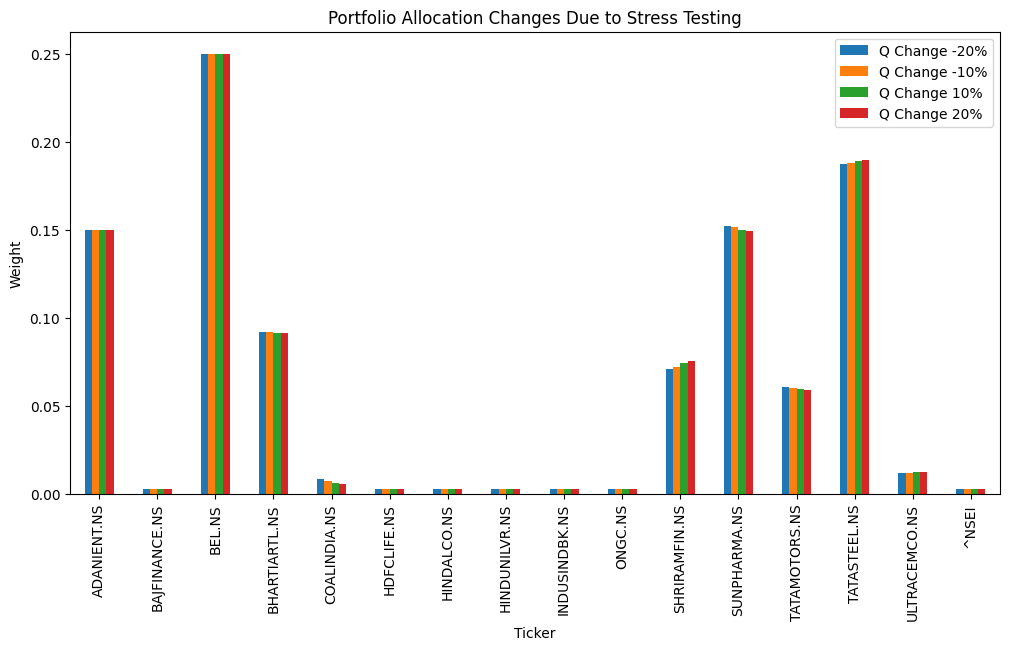

In [25]:
import copy
import numpy as np
import matplotlib.pyplot as plt

def sensitivity_analysis(returns, P, Q, omega, tau, cov_matrix, risk_free_rate, sector_mapping, sector_limits, changes=[-0.2, -0.1, 0.1, 0.2]):
    """
    Perform stress testing by adjusting subjective views (Q) and checking impact on portfolio allocation.

    Parameters:
    - returns: Stock returns
    - P: Pick matrix
    - Q: Subjective views on excess returns
    - omega: Confidence matrix
    - tau: Scaling factor
    - cov_matrix: Covariance matrix
    - risk_free_rate: Risk-free rate
    - sector_mapping: Dictionary of stock-to-sector mapping
    - sector_limits: Dictionary of sector allocation limits
    - changes: List of percentage changes to apply to Q (default: [-20%, -10%, +10%, +20%])

    Returns:
    - allocations: Dictionary with portfolio weights under different scenarios
    """
    original_Q = copy.deepcopy(Q)
    allocations = {}

    for change in changes:
        adjusted_Q = original_Q * (1 + change)  # Modify views by ±10%, ±20%

        # Compute adjusted Black-Litterman
        inv_tau_cov = np.linalg.pinv(tau * cov_matrix)
        inv_omega = np.linalg.pinv(omega)
        M_inverse = np.linalg.pinv(inv_tau_cov + P.T @ inv_omega @ P)
        posterior_mean = M_inverse @ (inv_tau_cov @ returns.mean().values.reshape(-1, 1) + P.T @ inv_omega @ adjusted_Q)

        # Normalize
        posterior_mean = np.clip(posterior_mean * 100, -5, 5)

        # Optimize portfolio with sector constraints
        optimized_weights = sector_constrained_optimization(returns, posterior_mean, sector_mapping, sector_limits)

        # Store
        allocations[f"Q Change {change*100:.0f}%"] = optimized_weights

    return allocations

# Run Sensitivity Analysis
sensitivity_results = sensitivity_analysis(returns, P, Q, omega, tau, cov_matrix, risk_free_rate, sector_mapping, sector_limits)

# Convert to DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results, index=returns.columns)
print(sensitivity_df)

# Plot
sensitivity_df.plot(kind="bar", figsize=(12,6), title="Portfolio Allocation Changes Due to Stress Testing")
plt.ylabel("Weight")
plt.show()

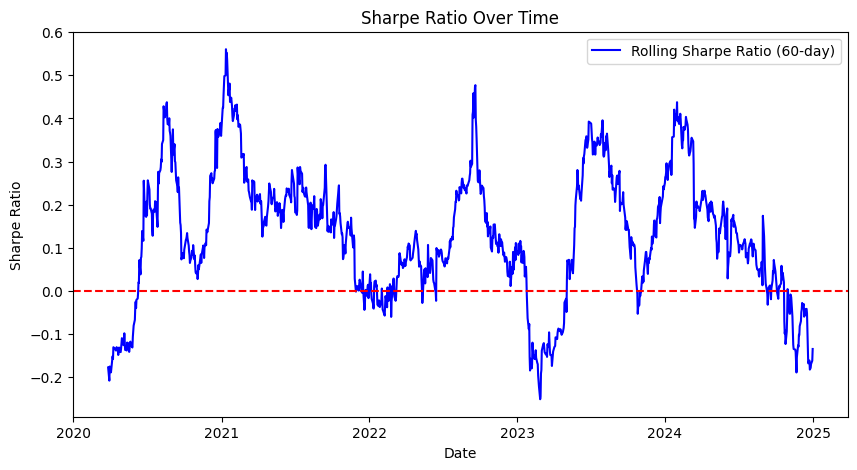

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rolling_sharpe_ratio(returns, window=60, risk_free_rate=0.07):
    excess_returns = returns - risk_free_rate / 252  # Convert annual risk-free rate to daily
    rolling_sharpe = excess_returns.rolling(window).mean() / excess_returns.rolling(window).std()
    return rolling_sharpe

rolling_sharpe = rolling_sharpe_ratio(portfolio_returns)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rolling_sharpe, label="Rolling Sharpe Ratio (60-day)", color='blue')
plt.axhline(y=0, color='red', linestyle='dashed')  # Reference line at 0
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Over Time")
plt.legend()
plt.show()


In [27]:
import yfinance as yf

nifty50_data = yf.download('^NSEI', start=start_date, end=end_date)['Close']

nifty50 = nifty50_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
<ipython-input-28-c34a29552f0d>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df_assets["Risk"][i], df_assets["Return"][i]), fontsize=12, xytext=(10,5), textcoords='offset points')
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element S

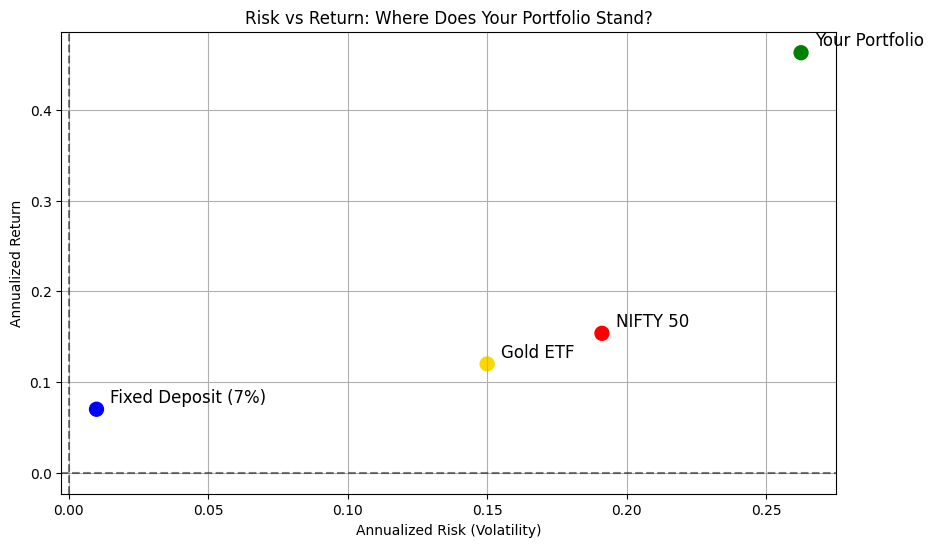

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_risk_return(returns):
    annual_return = returns.mean() * 252  # Annualized return
    annual_volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    return annual_return, annual_volatility

# Portfolio metrics
portfolio_return, portfolio_risk = compute_risk_return(portfolio_returns)

# Benchmark (NIFTY 50) metrics
nifty50_return, nifty50_risk = compute_risk_return(nifty50)

sample_assets = {
    "NIFTY 50": (nifty50_return, nifty50_risk),
    "Fixed Deposit (7%)": (0.07, 0.01),  # Approx. for risk-free investment
    "Gold ETF": (0.12, 0.15),  # Approximate return & risk for Gold ETFs
}

# Convert
df_assets = pd.DataFrame(sample_assets, index=["Return", "Risk"]).T
df_assets.loc["Your Portfolio"] = [portfolio_return, portfolio_risk]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_assets["Risk"], df_assets["Return"], color=['red', 'blue', 'gold', 'green'], s=100)

# Annotate points
for i, txt in enumerate(df_assets.index):
    plt.annotate(txt, (df_assets["Risk"][i], df_assets["Return"][i]), fontsize=12, xytext=(10,5), textcoords='offset points')

# Labels
plt.xlabel("Annualized Risk (Volatility)")
plt.ylabel("Annualized Return")
plt.title("Risk vs Return: Where Does Your Portfolio Stand?")
plt.axhline(y=0, color='black', linestyle='dashed', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='dashed', alpha=0.5)
plt.grid(True)
plt.show()